/home/nsmsc/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


X_train shape: (6276, 26)
y_train shape: (6276, 4)
First few rows of X_train:
    unique_collection_ids  non_unique_collection_ids  unique_machine_ids  \
0                     21                          2                  23   
1                     14                          0                  14   
2                     16                          5                  22   
3                     14                          0                  14   
4                     17                          3                  20   

   interval_start  sum_avg_cpu_lag_1  sum_avg_memory_lag_1  sum_max_cpu_lag_1  \
0          1200.0           0.168282              0.103754           0.814924   
1          1500.0           0.068888              0.081355           0.338942   
2          1800.0           0.041991              0.039262           0.429966   
3          2100.0           0.079906              0.077510           0.327903   
4          2400.0           0.106662              0.066726       

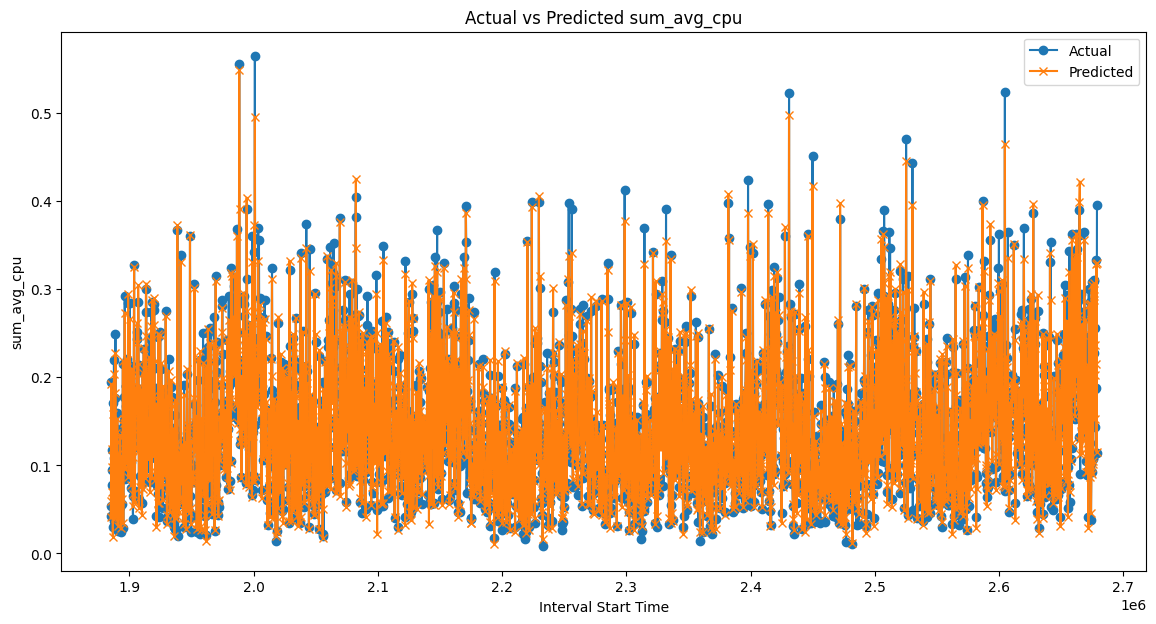

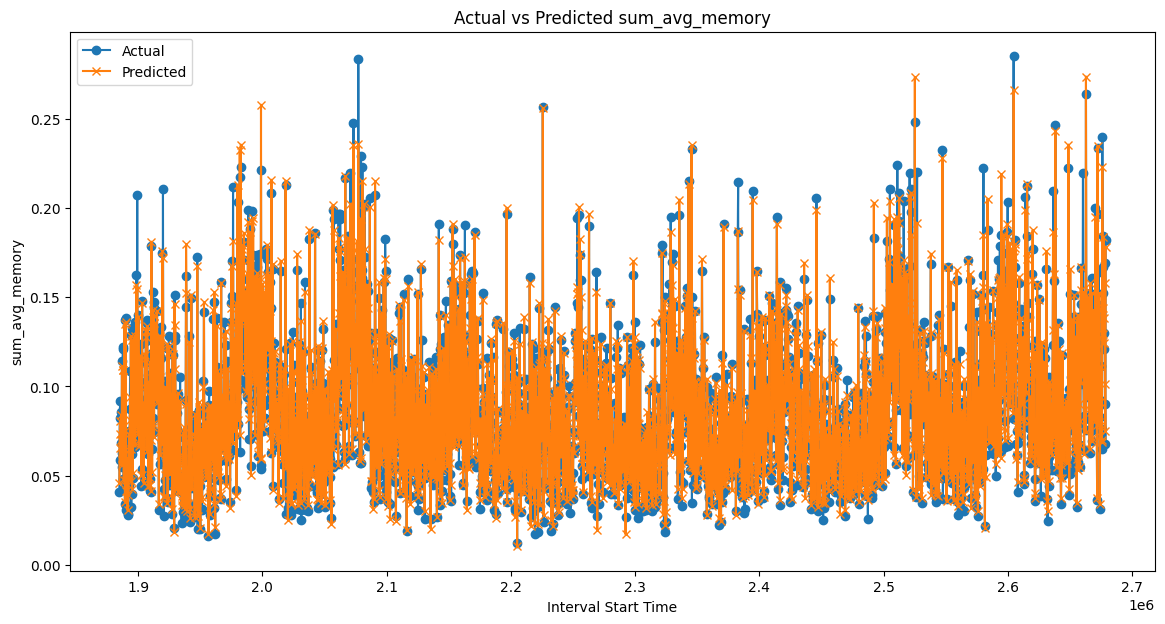

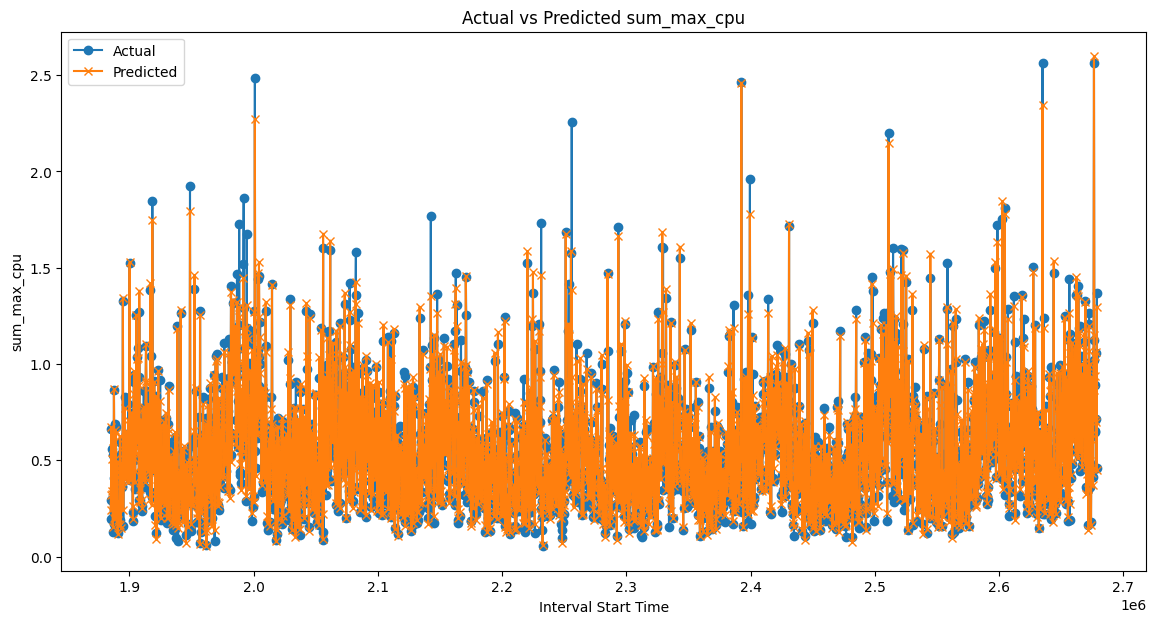

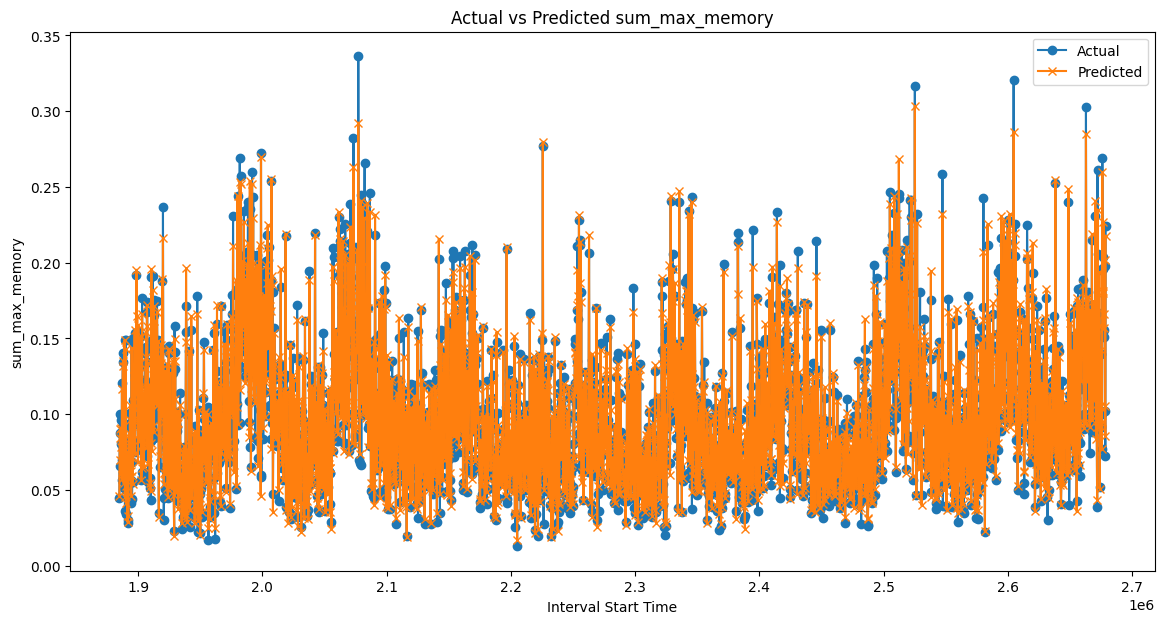

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    # Calculate the count of each collection_id within this interval
    collection_id_counts = interval_data['collection_id'].value_counts()

    # Identify collection_ids that appear more than once (non-unique)
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()

    # Calculate unique collection_id counts
    unique_collection_ids_count = interval_data['collection_id'].nunique()

    # Unique machine_id counts
    unique_machine_ids_count = interval_data['machine_id'].nunique()

    # Usage sums
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()

    return {
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()

    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            interval_result['interval_start'] = current_start  # Add start time to results
            results.append(interval_result)
        current_start = current_end

    df = pd.DataFrame(results)

    # Add lag features
    for lag in range(1, 4):  # Create lag features for 1, 2, 3 intervals back
        df[f'sum_avg_cpu_lag_{lag}'] = df['sum_avg_cpu'].shift(lag)
        df[f'sum_avg_memory_lag_{lag}'] = df['sum_avg_memory'].shift(lag)
        df[f'sum_max_cpu_lag_{lag}'] = df['sum_max_cpu'].shift(lag)
        df[f'sum_max_memory_lag_{lag}'] = df['sum_max_memory'].shift(lag)

    # Add rolling statistics features
    rolling_window = 3  # Set window size for rolling statistics
    df['sum_avg_cpu_rolling_mean'] = df['sum_avg_cpu'].rolling(window=rolling_window).mean()
    df['sum_avg_memory_rolling_mean'] = df['sum_avg_memory'].rolling(window=rolling_window).mean()
    df['sum_max_cpu_rolling_mean'] = df['sum_max_cpu'].rolling(window=rolling_window).mean()
    df['sum_max_memory_rolling_mean'] = df['sum_max_memory'].rolling(window=rolling_window).mean()

    df['sum_avg_cpu_rolling_std'] = df['sum_avg_cpu'].rolling(window=rolling_window).std()
    df['sum_avg_memory_rolling_std'] = df['sum_avg_memory'].rolling(window=rolling_window).std()
    df['sum_max_cpu_rolling_std'] = df['sum_max_cpu'].rolling(window=rolling_window).std()
    df['sum_max_memory_rolling_std'] = df['sum_max_memory'].rolling(window=rolling_window).std()

    # Add time-based features
    df['hour_of_day'] = pd.to_datetime(df['interval_start'], unit='s').dt.hour
    df['day_of_week'] = pd.to_datetime(df['interval_start'], unit='s').dt.dayofweek

    # Drop initial rows with NaNs (from lagging and rolling)
    df = df.dropna().reset_index(drop=True)

    return df

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)


train_features = prepare_features(train_data)

test_features = prepare_features(test_data)


X_train = train_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory'])
y_train = train_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]

# Check for empty dataframes and shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("First few rows of X_train:\n", X_train.head())
print("First few rows of y_train:\n", y_train.head())

# Initialize XGBoost model
models = {}
for target in y_train.columns:
    models[target] = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    models[target].fit(X_train, y_train[target])

# Prepare the testing features
X_test = test_features.drop(columns=['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory'])
y_test = test_features[['sum_avg_cpu', 'sum_avg_memory', 'sum_max_cpu', 'sum_max_memory']]

# Check for empty dataframes and shapes
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("First few rows of X_test:\n", X_test.head())
print("First few rows of y_test:\n", y_test.head())


y_pred = pd.DataFrame()
for target in y_test.columns:
    y_pred[target] = models[target].predict(X_test)

for target in y_test.columns:
    mse = mean_squared_error(y_test[target], y_pred[target])
    print(f"Mean Squared Error for {target}: {mse}")


result_df = pd.concat([test_features.reset_index(drop=True), y_pred.add_suffix('_pred')], axis=1)
print(result_df.head())


for target in y_test.columns:
    r2 = r2_score(y_test[target], y_pred[target])
    accuracy_percentage = r2 * 100
    print(f"Accuracy for {target}: {accuracy_percentage:.2f}%")


def plot_actual_vs_predicted(test_features, y_test, y_pred, target):
    plt.figure(figsize=(14, 7))
    plt.plot(test_features['interval_start'], y_test[target].values, label='Actual', marker='o')
    plt.plot(test_features['interval_start'], y_pred[target].values, label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted {target}')
    plt.xlabel('Interval Start Time')
    plt.ylabel(target)
    plt.legend()
    plt.show()


for target in y_test.columns:
    plot_actual_vs_predicted(test_features, y_test, y_pred, target)


In [3]:
from sklearn.metrics import mean_absolute_error


def calculate_metrics(y_test, y_pred, target):
    mse = mean_squared_error(y_test[target], y_pred[target])
    mae = mean_absolute_error(y_test[target], y_pred[target])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test[target] - y_pred[target]) / y_test[target])) * 100

    return mse, mae, rmse, mape


for target in y_test.columns:
    mse, mae, rmse, mape = calculate_metrics(y_test, y_pred, target)
    print(f"{target}:\n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n MAPE: {mape}%\n")


sum_avg_cpu:
 MSE: 0.0001774192732150943
 MAE: 0.008996834381558268
 RMSE: 0.013319882627677103
 MAPE: 7.814597173071173%

sum_avg_memory:
 MSE: 5.809144342583302e-05
 MAE: 0.004933858238118671
 RMSE: 0.007621774296437347
 MAPE: 6.361791100275595%

sum_max_cpu:
 MSE: 0.003467218235238412
 MAE: 0.03674073383368158
 RMSE: 0.05888308955242084
 MAPE: 7.85950508148571%

sum_max_memory:
 MSE: 8.121198053006596e-05
 MAE: 0.006118536189718212
 RMSE: 0.009011769001148773
 MAPE: 6.941270547533246%

